In [5]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
projects = pd.read_csv("projects.csv")
donations = pd.read_csv("donations.csv")
outcomes = pd.read_csv("outcomes.csv")

## Data Exploration

In [3]:
donations.columns

Index(['donationid', 'projectid', 'donor_acctid', 'donor_city', 'donor_state',
       'donor_zip', 'is_teacher_acct', 'donation_timestamp',
       'donation_to_project', 'donation_optional_support', 'donation_total',
       'dollar_amount', 'donation_included_optional_support', 'payment_method',
       'payment_included_acct_credit', 'payment_included_campaign_gift_card',
       'payment_included_web_purchased_gift_card', 'payment_was_promo_matched',
       'via_giving_page', 'for_honoree', 'donation_message'],
      dtype='object')

In [4]:
outcomes.columns

Index(['projectid', 'is_exciting', 'at_least_1_teacher_referred_donor',
       'fully_funded', 'at_least_1_green_donation', 'great_chat',
       'three_or_more_non_teacher_referred_donors',
       'one_non_teacher_referred_donor_giving_100_plus',
       'donation_from_thoughtful_donor', 'great_messages_proportion',
       'teacher_referred_count', 'non_teacher_referred_count'],
      dtype='object')

In [5]:
donation_amounts = donations["donation_total"]


In [6]:
n, bins, patches = plt.hist(donation_amounts, 30, log=True)

A logarithm scaled donation histogram. This representation shows the severe right skew of donation amounts, as is to be expected given the proclivity of donors toward small donations and the occasional large estate or corporate donation. The same can be seen below in the sizeable gap between the mean and median donation numbers.

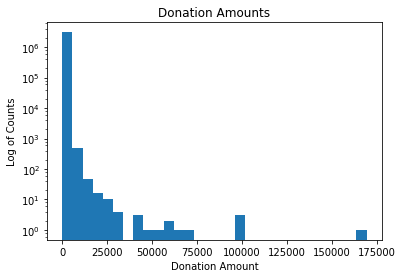

In [7]:
plt.xlabel('Donation Amount')
plt.ylabel('Log of Counts')
plt.title('Donation Amounts')
plt.show()

In [8]:
print("The maximum donation was: ", max(donation_amounts))
print("The mean donation is: ", np.average(donation_amounts))
print("The median donation is: ", np.median(donation_amounts))
print("The sum of donations has been: ", sum(donation_amounts))



The maximum donation was:  169200.0
The mean donation is:  76.6769073486
The median donation is:  25.0
The sum of donations has been:  237544215.52


Given these figures, it may be useful to examine just the lower portion of the graph to examine if it also displays high skew

In [9]:
np.percentile(donation_amounts, 70)


50.0

In [10]:
lower_donations = donation_amounts[donation_amounts[:] <= 55]

In [11]:
n, bins, patches = plt.hist(lower_donations, 30)

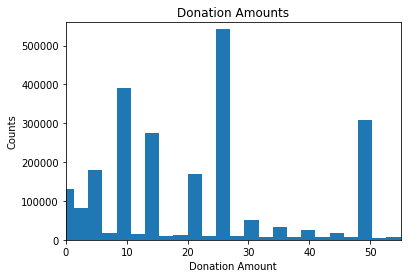

In [12]:
plt.xlabel('Donation Amount')
plt.ylabel('Counts')
plt.title('Donation Amounts')
plt.axis([0,55, 0, 560000])
plt.show()

Thus, we can see that most donations gravitate to multiples of 5, especially at 25 dollars. 

In [13]:
low_proportion_dollars = sum(lower_donations)/sum(donation_amounts)
low_proportion_counts = len(lower_donations)/len(donation_amounts)
print("Donations below $50 are responsible for {:0.2f}% of the money raised.".format(low_proportion_dollars*100))
print("Donations below $50 are responsible for {:0.2f}% of the donations received.".format(low_proportion_counts*100))

Donations below $50 are responsible for 20.70% of the money raised.
Donations below $50 are responsible for 74.93% of the donations received.


Thus, as we can see here, the donations are a nearly textbook example of the Pareto Principle, therefore it is often advantageous to do what is classically advised in these situations: focus on the 25% of donors responsible for the 80% of money received.

Now that we have some insight into the distribution of donations received, I will turn my attention toward the projects, particularly quantifying those which are interesting. I will start with the variables listed in the the projects dataset, particularly those which are bernoulli in distribution. I will test each for independence from the outcome is_exciting. First therefore, I need a list of the bernoulli variables and a version of the projects dataset that has is_exciting included. 

In [10]:
projects_with_outcomes = pd.merge(projects, outcomes, on='projectid')

In [15]:
projects_with_outcomes

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,...,f,t,f,t,t,t,f,80.0,0.0,6.0
1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,...,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,...,f,f,t,f,f,f,f,NaN,0.0,2.0
3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,...,f,f,t,f,f,f,f,NaN,0.0,1.0
4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,...,f,t,t,f,f,t,f,50.0,0.0,2.0
5,c685c844476d7ed75bf87699eeafd682,4b19500fb087a635c98061505f1e6c6f,34c650f9f6d5c3e42b8e2169c280ecb7,NaN,34.193630,-79.769058,Florence,SC,29501.0,urban,...,t,f,t,f,f,f,f,0.0,2.0,0.0
6,a4b234feb2b72921ed59850d5c873d62,620982375045fa11d872702f26ab98bb,da1985df161ba5c3842fc99579b6e4b1,2.102990e+11,38.249919,-85.722310,Louisville,KY,40206.0,urban,...,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
7,0ff5dec32bf793243a8b0b2c023a81f0,ec5b110df87bd511b508961676d08b6c,72e2b0cb2eecfdc37e67e0eaf10da07b,1.201980e+11,30.507978,-86.132003,Freeport,FL,32439.0,rural,...,f,t,t,t,t,t,f,100.0,0.0,3.0
8,8cdbc04c8ee2ae6afed4951727488579,697e3ea37463219c27f9652b2287c844,5ad205c4692c53cd0f5fcdfca2322a86,1.201440e+11,28.546640,-81.388606,Orlando,FL,32801.0,urban,...,t,t,t,f,f,f,f,50.0,3.0,2.0
9,72d58b8e22adbe6e6aab65d8b2ab4973,0793851e2f40ecc28e40513622aea670,a180e99ef60be5a9c5f96e21f9868f13,5.606090e+11,44.097156,-104.622147,Upton,WY,82730.0,rural,...,t,t,t,t,t,t,f,75.0,5.0,3.0


In [16]:
bern_variables = ['school_charter',
       'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp',
       'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', "eligible_double_your_impact_match", "eligible_almost_home_match"]

school_charter
            0        1        2
0      Actual  Other T  Other F
1  Exciting T     5074    31636
2  Exciting F    48310   534306 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T  3164.29  33545.7
2  Exciting F  50219.7   532396
The chi-squared statistic is :  1340  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  0.0


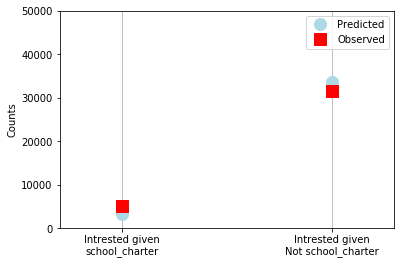

---------

school_magnet
            0        1        2
0      Actual  Other T  Other F
1  Exciting T     3371    33339
2  Exciting F    55144   527472 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T  3468.42  33241.6
2  Exciting F  55046.6   527569
The chi-squared statistic is :  3  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  0.0730766848306


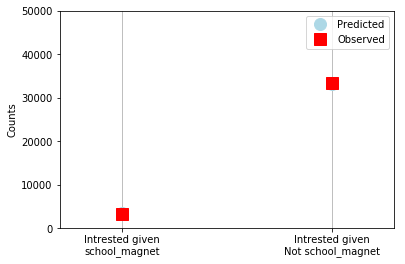

---------

school_year_round
            0        1        2
0      Actual  Other T  Other F
1  Exciting T     1614    35096
2  Exciting F    29434   553182 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T  1840.34  34869.7
2  Exciting F  29207.7   553408
The chi-squared statistic is :  31  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  2.3840004415e-08


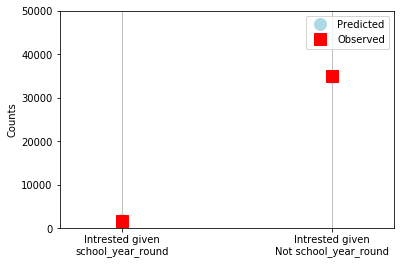

---------

school_nlns
            0        1        2
0      Actual  Other T  Other F
1  Exciting T      727    35983
2  Exciting F     8861   573755 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T   568.32  36141.7
2  Exciting F  9019.68   573596
The chi-squared statistic is :  47  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  4.63185045874e-12


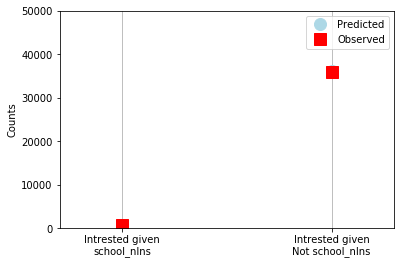

---------

school_kipp
            0        1        2
0      Actual  Other T  Other F
1  Exciting T      489    36221
2  Exciting F     3705   578911 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T  248.596  36461.4
2  Exciting F   3945.4   578671
The chi-squared statistic is :  248  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  0.0


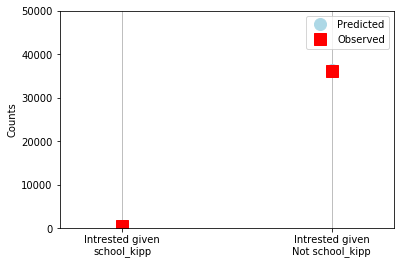

---------

teacher_teach_for_america
            0        1        2
0      Actual  Other T  Other F
1  Exciting T     3882    32828
2  Exciting F    32203   550413 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T  2138.91  34571.1
2  Exciting F  33946.1   548670
The chi-squared statistic is :  1603  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  0.0


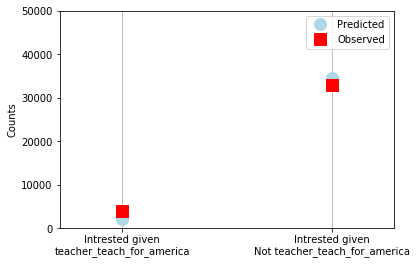

---------

teacher_ny_teaching_fellow
            0        1        2
0      Actual  Other T  Other F
1  Exciting T      563    36147
2  Exciting F    10508   572108 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T  656.224  36053.8
2  Exciting F  10414.8   572201
The chi-squared statistic is :  14  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  0.000153064240955


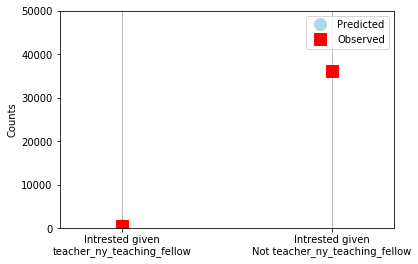

---------

eligible_double_your_impact_match
            0        1        2
0      Actual  Other T  Other F
1  Exciting T     9685    27025
2  Exciting F   161638   420978 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T    10155    26555
2  Exciting F   161168   421448
The chi-squared statistic is :  31  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  1.56673837237e-08


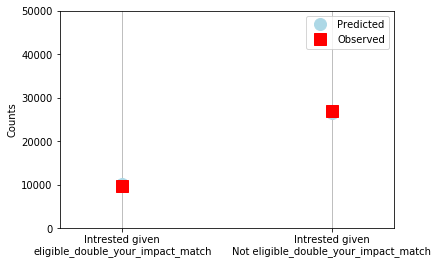

---------

eligible_almost_home_match
            0        1        2
0      Actual  Other T  Other F
1  Exciting T     2061    34649
2  Exciting F    35395   547221 

            0        1        2
0   Predicted  Other T  Other F
1  Exciting T  2220.17  34489.8
2  Exciting F  35235.8   547380
The chi-squared statistic is :  12  with 1 df.
The P-value for this divergence under a chi-squared test of independance is:  0.000326589373139


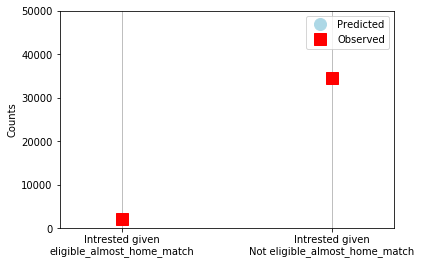

---------



In [17]:
observed_array = pd.DataFrame([["Actual", "Other T", "Other F"], ["Exciting T", "", ""], ["Exciting F", "", ""]])
predicted_array = pd.DataFrame([["Predicted", "Other T", "Other F"], ["Exciting T", "", ""], ["Exciting F", "", ""]], index=None)

for other_var in bern_variables:
    
    print(other_var)
    
    both_t = len(projects_with_outcomes[(projects_with_outcomes["is_exciting"] == "t") & (projects_with_outcomes[other_var] == "t")])
    interest_t_other_f = len(projects_with_outcomes[(projects_with_outcomes["is_exciting"] == "t") & (projects_with_outcomes[other_var] == "f")])
    interest_f_other_t = len(projects_with_outcomes[(projects_with_outcomes["is_exciting"] == "f") & (projects_with_outcomes[other_var] == "t")])
    neither_t = len(projects_with_outcomes[(projects_with_outcomes["is_exciting"] == "f") & (projects_with_outcomes[other_var] == "f")])
    
    total_interest_t = both_t + interest_t_other_f
    total_interest_f = neither_t + interest_f_other_t
    total_other_t = both_t + interest_f_other_t
    total_other_f = neither_t + interest_t_other_f
    total = total_interest_t + total_interest_f
    
    
    #The expected counts under the null hypthosis that is_exciting and other_var are independant
    pred_both_t = (total_interest_t * total_other_t)/total
    pred_interest_t_other_f = (total_interest_t * total_other_f)/total 
    pred_interest_f_other_t = (total_interest_f * total_other_t)/total 
    pred_neither_t = (total_interest_f * total_other_f)/total
    
    
    # Filling the arrays of observed and predicted for easier viewing
    observed_array.iloc[1,1] = both_t
    observed_array.iloc[1,2] = interest_t_other_f
    observed_array.iloc[2,1] = interest_f_other_t
    observed_array.iloc[2,2] = neither_t
    predicted_array.iloc[1,1] = pred_both_t
    predicted_array.iloc[1,2] = pred_interest_t_other_f
    predicted_array.iloc[2,1] = pred_interest_f_other_t
    predicted_array.iloc[2,2] = pred_neither_t

    names = ["Intrested given\n" + other_var, "Intrested given\n" + "Not " + other_var]
    predicted = [pred_both_t, pred_interest_t_other_f]
    
    observed = [both_t, interest_t_other_f]
    

    fig, ax = plt.subplots()
    ax.plot(predicted, color='lightblue', marker='o', linestyle='none',
            markersize=12, label='Predicted')
    ax.plot(observed, color='red', marker='s', linestyle='none',
            markersize=12, label='Observed')

    ax.margins(.3)
    ax.set_ylim([0, 50000])
    ax.set(xticks=range(len(names)), xticklabels=names, ylabel='Counts')
    ax.legend(loc='best', numpoints=1)
    ax.grid(axis='x')
    
    #Now that the figure is shown, calculating the chi-squared test of independance
    chi_stat = 0
    observeds = [both_t, interest_t_other_f, interest_f_other_t, neither_t]
    expecteds = [pred_both_t, pred_interest_t_other_f, pred_interest_f_other_t, pred_neither_t]
    for i in range(4):
        chi_stat += ((observeds[i] - expecteds[i])**2) / expecteds[i]
    
    print(observed_array, "\n")
    print
    print(predicted_array)
    
    p_val = 1 - stats.chi2.cdf(chi_stat, 1)
    print("The chi-squared statistic is : ", int(chi_stat), " with 1 df.")
    print("The P-value for this divergence under a chi-squared test of independance is: ", p_val)
    plt.show()
    print('---------\n')
    






From these tests of independence, we can see many of the variables are statistically not independent, especially teacher_teach_for_america, which is an interesting result in and of itself. It also indicates that a strong logistic model could be constructed from these bernoulli variables alone. 


## Interesting Data Story

Next, to find an interesting story in the data, I will follow my earlier advice and begin with the top donations, looking for large donations to projects that are not exciting.

In [18]:
donations.columns


Index(['donationid', 'projectid', 'donor_acctid', 'donor_city', 'donor_state',
       'donor_zip', 'is_teacher_acct', 'donation_timestamp',
       'donation_to_project', 'donation_optional_support', 'donation_total',
       'dollar_amount', 'donation_included_optional_support', 'payment_method',
       'payment_included_acct_credit', 'payment_included_campaign_gift_card',
       'payment_included_web_purchased_gift_card', 'payment_was_promo_matched',
       'via_giving_page', 'for_honoree', 'donation_message'],
      dtype='object')

In [19]:
upper_donations = donations[donation_amounts[:] >= 20000]
len(upper_donations)

34

In [20]:
# The below code prints the project id's of the 34 donations over $20,000 and whether or not they were interesting. 
# The shorter indent on the second line is students reached by interesting projects. The longer is students reached by uninteresting ones
count = 0
for index, dona in upper_donations.iterrows():
    outcome = outcomes[outcomes.projectid == dona.projectid]
    project = projects[projects.projectid == dona.projectid]
    print(dona.projectid, dona.donationid, dona.donation_total)
    if outcome["is_exciting"].iloc[0] == "f":
        count += 1
        print("      ", project.students_reached.iloc[0], "Uninteresting")
    else:
        print("   ", project.students_reached.iloc[0], "Interesting")
        
print(count)        


e45cbcd16ba1db6a11e01adcda52d5ac 8cb97adbdd0660e051ee96166408dffd 24371.48
       120.0 Uninteresting
dcd8bbb3016627ea36aa43a283183959 88ffa0453dad4a6c79758dd3a11cdafb 20000.0
    40.0 Interesting
dc106a943920d1fbe1f4f079c212c732 4367e69b4d758fc75c9b5e868d6b6aa0 25000.0
       440.0 Uninteresting
dc106a943920d1fbe1f4f079c212c732 c71f833b9d26ff5d4d3e8ad025fd7fcb 100000.0
       440.0 Uninteresting
dc106a943920d1fbe1f4f079c212c732 0ee455b42d2cdc5eb07b041c37052e88 33475.41
       440.0 Uninteresting
c434c0c54ddef4263f1813bc8fc61962 3822b87e18f93789a7306ac2bd8a4f03 22990.0
    18.0 Interesting
c1476d557b16f58cefe2244ecd526bd0 2a9e7bf2ce74d75a9a9eac611f4bbdee 43333.0
       104.0 Uninteresting
ba5b7f48dc4014184e4dfa23d7927ec9 bac53805448e2dcfdf4ad6f635ce6ddf 31875.01
       650.0 Uninteresting
b13aaa06baad031277fdd7c7f7370c02 8731fe0e534c3e95af99cc60898d0f06 60000.0
       110.0 Uninteresting
ad19531b5f4900560e79cf9d6c706dd9 3c017dd0c8939a8d5d4a34041d2b4518 26369.03
    70.0 Interesting
a91

From this, we can see an interesting aspect of the data, namely that interesting projects are not necessarily those that impact a higher number of students, meaning that the factors given by Donors Choose as quantifing an interesting project are seeminly not correlated with students reached. In fact, there is one  22,000 dollar donation to a project that only effected one student that was marked interesting. However, another donation is for 72,000 dollars for a project affecting 9,300 students but was not marked interesting. I will examine further the stroy of this large donation and this project. The project ID is 673c3a83504105c1a260e6573993ca54 and the donation id is 566abd75186e1fd647f3ec46036b8139. Note that an interesting analysis would also be to perform correlation analysis on  the connection of each one of the bernoulli variables in the outcomes dataset with number of students reached using chi-squared tests of independance. 

In [21]:
# First, I will look at the information on the donation.
pd.set_option('display.max_columns', None)
upper_donations[upper_donations.donationid == "566abd75186e1fd647f3ec46036b8139"]

,donationid,projectid,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message
1849075,566abd75186e1fd647f3ec46036b8139,673c3a83504105c1a260e6573993ca54,b446001d4a324d4437ec47be9f566972,New York,NY,10001.0,f,2012-05-07 23:46:19.269,61821.2,10909.62,72730.82,100_and_up,t,no_cash_received,t,f,f,f,t,f,The Bully Project - 1 Million Kids is helping ...


In [22]:
projects[projects.projectid == "673c3a83504105c1a260e6573993ca54"]

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted
250991,673c3a83504105c1a260e6573993ca54,6cb5bdc5f1822cbdba3fc228f1c8fc26,004d381fc2813d6acc92e9e0fc6599ea,3.904375e+11,39.113407,-84.585823,Cincinnati,OH,45205.0,urban,Cincinnati City Sch District,Hamilton,f,f,f,f,f,f,Ms.,f,f,Character Education,Applied Learning,NaN,NaN,Trips,highest poverty,Grades 9-12,35.0,72730.82,85565.67,9296.0,f,f,2012-05-03


In [23]:
outcomes[outcomes.projectid == "673c3a83504105c1a260e6573993ca54"]

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
369513,673c3a83504105c1a260e6573993ca54,f,f,t,f,f,f,t,f,0.0,0.0,2.0


In [24]:
donations[donations.projectid == "673c3a83504105c1a260e6573993ca54"]

,donationid,projectid,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message
1849074,82a016276bc2f5d7d42ec9a96c79ea1c,673c3a83504105c1a260e6573993ca54,4fc7c5f817098fefd0bdedd4a0cd4410,NaN,NaN,NaN,f,2012-05-07 23:47:32.943,10909.62,1925.23,12834.85,100_and_up,t,no_cash_received,t,f,f,f,t,f,NaN
1849075,566abd75186e1fd647f3ec46036b8139,673c3a83504105c1a260e6573993ca54,b446001d4a324d4437ec47be9f566972,New York,NY,10001.0,f,2012-05-07 23:46:19.269,61821.20,10909.62,72730.82,100_and_up,t,no_cash_received,t,f,f,f,t,f,The Bully Project - 1 Million Kids is helping ...


In [25]:
# projectid guaranteed to be unique - avoiding loading the entire dataset into memory because RAM is limited
essay_list = []
with open("essays.csv", "r") as f:
    for line in f:
        line = line.split(",")
        if line[0] == "673c3a83504105c1a260e6573993ca54":
            essay_list = line
            break

In [26]:
for i in essay_list:
    print(i, "\n")

673c3a83504105c1a260e6573993ca54 

6cb5bdc5f1822cbdba3fc228f1c8fc26 

Bully Project 

Cincinnati Public Schools was invited to be the first district to become involved in the Bully Project.Through the efforts of the District-wide Discipline Committee and the Positive School Culture... 

My students need buses and tickets to see the Bullying movie. 

"Cincinnati Public Schools was invited to be the first district to become involved in the Bully Project.
 



After collating the data, we can see why number of students is not correlated with exciting status for this data point. Although this particular project affects many students, it was ultimately funded by only two very large donations. This means that it was unlikely to be able to fulfill all the neccessary conditions for exciting status. Further, we can see more of a story of this particular project in the data. Specifically, it appears that the project involved taking an entire high school or sizable percentage of the school to participate in "The Bully Project", a documentary and accompanining project to show students across the contry the stories of bullied children. In addition, we can see that both donations to the project, which ended up more than fulfilling its need originated in New York, NY a mere 4 days after the project was posted and less than a minute apart. However, the school requesting the funds is in Cinncinatti OH. Therefore, it seems likely that the donations came from a company or the The Bully Project foundation itself. In fact, a short internet search reveals that the national headquarters for the Bully Project are at 18 W. 27th St. 2nd Floor New York, NY 10001, the same zip code as one of the donations. In total, therefore, we can see that this project was part of a coordinated national project instead of a grass-roots/crowd funded project that DonorsChoose.org seems to be attempting to quantify with their exciting status. 

## Additional Data/Questions

A crucial piece of set of data that is missing from this analysis is unquestionably donor demographics. In specific, I would think the best information to query or gather would be, for each unique donor: Age Range, Gender, Educational Level, How they found out about the project they donated, general donation areas of interest, financial range, family status (married, number of children). Of course, this information would need to be optional, but, if given, this kind of detail could open entirely new doors for the researchers. Specifically, the analysts at donor choose could begin quantifying projects as exciting based on targeted demographics instead of a static set of criteria. And beyond the quantification of exciting status, this data could also permit the analysts to identify donors of high potential. For example, only considering individual donors (as opposed to organizations), a middle age donor without children could become a high value asset, especially if presented with projects that match their past donation history, or, more granularly, their general interests. 

In addition, this kind of data would permit a organization wide survey of demographics under represented in donations, which can drive strategic decisions on advertising, hiring, and projects prioritized. 

It is understandable why this information was not included in this research project, but its addition would prove invaluable for further analysis.

## Modeling

Disclaimer: At present, my classwork has not yet reached into the realm of machine learning. It is, however, my goal moving forward to learn ML to my utmost ability, and so therefore it would be my hope to continuously gain knowledge I could apply to research with the DSaPP group. So to this end, I will apply what I can currently about logistic regression on the outcomes data which I mentioned earlier to model fully_funded. Of course, to prevent overfitting, I will concentrate on the variables identified earlier as being most strongly assosciated with is_exciting, since fully_funded is required. I will also add other variables as well.

In [11]:
training = projects_with_outcomes[309663:][['school_charter','school_kipp','teacher_teach_for_america','primary_focus_area','poverty_level','grade_level', 'fully_funded']]

In [12]:
dummies = pd.get_dummies(training, prefix= ['school_charter','school_kipp','teacher_teach_for_america','primary_focus_area','poverty_level','grade_level', 'fully_funded'])


In [13]:
# deleting some of the fields to prevent perfect multicollinearity
dummies.drop([ 'school_charter_f',
       'school_kipp_f', 
       'teacher_teach_for_america_f',
       'primary_focus_area_Applied Learning', 
       'poverty_level_moderate poverty', 
       'grade_level_Grades PreK-2',
       'fully_funded_f'], inplace=True, axis=1)

dummies['intercept'] = 1

In [14]:
predictors = list(dummies.columns)
predictors.remove('fully_funded_t')
predictors

['school_charter_t',
 'school_kipp_t',
 'teacher_teach_for_america_t',
 'primary_focus_area_Health & Sports',
 'primary_focus_area_History & Civics',
 'primary_focus_area_Literacy & Language',
 'primary_focus_area_Math & Science',
 'primary_focus_area_Music & The Arts',
 'primary_focus_area_Special Needs',
 'poverty_level_high poverty',
 'poverty_level_highest poverty',
 'poverty_level_low poverty',
 'grade_level_Grades 3-5',
 'grade_level_Grades 6-8',
 'grade_level_Grades 9-12',
 'intercept']

In [15]:
logit_regression = sm.Logit(dummies['fully_funded_t'], dummies[predictors])

In [16]:
logit_fit = logit_regression.fit()

Optimization terminated successfully.
         Current function value: 0.338699
         Iterations 6


In [17]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         fully_funded_t   No. Observations:               309663
Model:                          Logit   Df Residuals:                   309647
Method:                           MLE   Df Model:                           15
Date:                Tue, 18 Jul 2017   Pseudo R-squ.:                 -0.2833
Time:                        21:45:27   Log-Likelihood:            -1.0488e+05
converged:                       True   LL-Null:                       -81727.
                                        LLR p-value:                     1.000
==========================================================================================================
                                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------
school_charter_t                           0.2386      0.016     14.722      0.000         0.207     0.270
school_kipp_t                              0.1590      0.059      2.682      0.007         0.043     0.275
teacher_teach_for_america_t                0.7291      0.019     37.979      0.000         0.692     0.767
primary_focus_area_Health & Sports         0.3295      0.027     12.195      0.000         0.277     0.382
primary_focus_area_History & Civics        0.3957      0.021     18.435      0.000         0.354     0.438
primary_focus_area_Literacy & Language     0.3162      0.014     22.192      0.000         0.288     0.344
primary_focus_area_Math & Science          0.5190      0.015     33.572      0.000         0.489     0.549
primary_focus_area_Music & The Arts        0.5728      0.019     30.493      0.000         0.536     0.610
primary_focus_area_Special Needs           0.2959      0.020     14.555      0.000         0.256     0.336
poverty_level_high poverty                 0.1545      0.013     11.893      0.000         0.129     0.180
poverty_level_highest poverty              0.5774      0.012     48.828      0.000         0.554     0.601
poverty_level_low poverty                  0.0665      0.028      2.348      0.019         0.011     0.122
grade_level_Grades 3-5                    -0.0828      0.010     -8.601      0.000        -0.102    -0.064
grade_level_Grades 6-8                    -0.1072      0.012     -9.249      0.000        -0.130    -0.084
grade_level_Grades 9-12                    0.1332      0.012     10.978      0.000         0.109     0.157
intercept                                 -0.0404      0.017     -2.370      0.018        -0.074    -0.007
==========================================================================================================
"""

We can see some great results from this analysis. Firstly, all the variables are quite significant (although the huge number of observations can skew this). Importantly, we can see that teach_for_america is a highly positive influencer, along with Music & the Arts and Highest Poverty level, and that lower grade levels are less likely to be fully funded.  

Now I will test this model against the second half of the data.

In [18]:
testing = projects_with_outcomes[:309662][['school_charter','school_kipp','teacher_teach_for_america','primary_focus_area','poverty_level','grade_level', 'fully_funded']]

In [19]:
dummies2 = pd.get_dummies(testing, prefix= ['school_charter','school_kipp','teacher_teach_for_america','primary_focus_area','poverty_level','grade_level', 'fully_funded'])


In [20]:
# deleting some of the fields to prevent perfect multicollinearity
dummies2.drop([ 'school_charter_f',
       'school_kipp_f', 
       'teacher_teach_for_america_f',
       'primary_focus_area_Applied Learning', 
       'poverty_level_moderate poverty', 
       'grade_level_Grades PreK-2',
       'fully_funded_f', 'fully_funded_t'], inplace=True, axis=1)

dummies2['intercept'] = 1

In [31]:
predictions = logit_fit.predict(dummies2, linear=True)
predictions_reg = []

In [32]:
predictions

array([ 0.17274504,  0.55025989,  0.3714319 , ...,  0.34747651,
        0.60411755,  0.76624951])

In [69]:
predicted_choice = (predictions > .5).astype(int)

In [70]:
actuals = dummies['fully_funded_t'].tolist()


In [71]:
correct = 0
total = 0
for i,j in zip(predicted_choice, actuals):
    if i == j:
        correct += 1
    total += 1   
        

In [72]:
print(correct/total)

0.5681840199959957


Unfortunately, this has only resulted in a small boost above chance at the 50% threshold. A different technique or process is probably needed, or a lower threshold. For example, a threshold of 30% results in 64% correct.